In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
nltk.download('punkt')
#import required libraries

def prepare_corpus(train_docs) -> list:
#return a list of documents
#pre-process text before calculations
 flag = False
 if isinstance(train_docs, str):
  flag = True
  train_docs = [train_docs]
#if passed a string, convert to a list so that function behaves as expected

 regex_pattern = re.compile(r'[^a-z0-9\s-]|(?<!\w)-|-(?!\w)')

#regex pattern matches non-alphanumeric characters, save hyphens that appear inbetween words to preserve meaning
 prepared_docs = []

 for text in train_docs:
   text = text.lower().strip()
   filtered_text = regex_pattern.sub('', text)
   tokenized_text = word_tokenize(filtered_text)
   prepared_docs.append(tokenized_text)

#loop through text in documents and preprocess

#return list of cleaned documents
#to avoid returning nested lists if this function is passed a string, check if flag is set to True - if so return the first list in prepared_docs
 return prepared_docs if not flag else prepared_docs[0]



def countWords(train_docs) -> list:
#return a list
#create word count dictionaries for N documents

  word_counts = []

  for document in train_docs:
    word_count = {}
    for word in document:
      if word in word_count:
        word_count[word] += 1
      else:
        word_count[word] = 1

#for each document in train_docs, count the frequency of words

    word_counts.append(word_count)

#append the created dictionary to a list

  return word_counts

def compute_tf(word_counts) -> list:
#return a list of computed tf value dicts
#helper function for compute_tfidf_weights

  tf_list = []

#initalize list to store computed tf value dicts for each document

  for word_count in word_counts:
    computed_tf = {}
    for word, count in word_count.items():
      computed_tf[word] = np.log10(count + 1)
    tf_list.append(computed_tf)

#for each dictionary, compute the tf of each stored word using the associated count
#add the computed term_frequencies for each document to list

  return tf_list


def compute_idf(list_of_word_count_dicts, N) -> dict:
    # Set comprehension creates a new set of unique words found in word_count dictionaries
    '''This comprehension works by iterating over each dictionary in the list of dictionaries, and then within
    an inner loop, iterating over each word in the current dictionary, adding it to the set, finally conversion to
    a set removes duplicate words'''
    unique_words = set(word for word_count_dict in list_of_word_count_dicts for word in word_count_dict)

    # Dictionary comprehension sums each time a word from our unique words set appears in count_dictionaries,
    #creates a new dictionary with the word as the key and number of occurrences as the value - this is the df
    df = {word: sum(1 for count_dict in list_of_word_count_dicts if word in count_dict) for word in unique_words}


    # Compute idf for each word in our set using a dictionary comprehension and previously computed df values
    idf = {word: np.log10(N / df_val) for word, df_val in df.items()}

    return idf


def compute_tfidf_weights(train_docs, word_counts, N) -> object:
#return pandas dataframe objects
  computed_tfs = compute_tf(word_counts)
  computed_idf = compute_idf(word_counts, N)
#call helper functions defined earlier
  docs_tf = pd.DataFrame(computed_tfs)
#convert computed_tf dictionaries into one dataframe
  docs_tf.fillna(0, inplace=True)
  '''As TF (term frequency) is calculated for each document, if we encounter any words that are not present in a given document,
     their TF value will be NaN. This code replaces these NaN values with 0s.'''

  docs_idf = pd.DataFrame.from_dict(computed_idf, orient='index')
  docs_idf.rename(columns={0: "IDF Value"}, inplace=True)
  #create a dataframe from the computed_idf dictionary, and set the title to IDF Value
  return docs_tf, docs_idf

def word_tfidf_vector(word, tf_df, idf_df, N, clean_output=True) -> object:
#return a numpy array object
 filtered_word = prepare_corpus(word)
 word = filtered_word[0]
 #preprocess word using earlier defined functions

 tf_idf_value = np.zeros(N)
 formatted_array = []
#create a new numpy array filled with N zeros
 for i in range(N):
  if word in idf_df.index:
#if the word is in our idf_df, which contains all words from our corpus - compute the tf_idf vector
#otherwise leave the value as 0
   tf_idf_value[i] = (tf_df.at[i, word]) * (idf_df.at[word, "IDF Value"])
  if clean_output:
    formatted_array.append(f"{tf_idf_value[i]} (Document{i+1})")

 if clean_output:
    print(f"Computed tf-idf vector for the word '{word}' is: {formatted_array}")
#To display the numpy array without the extra whitespaces call function with clean_output
#by default set to True, to see the raw numpy array, call function with clean_output=False


 return tf_idf_value

def create_tf_idf_matrix(sentence, tf_df, idf_df, N) -> object:
#return a dataframe object
#calculate the tf_idf for multiple words and store in a dataframe

  sentence = prepare_corpus(sentence)
#preprocess sentence

  tf_idf_dict = {word: word_tfidf_vector(word, tf_df, idf_df, N, clean_output=False) for word in sentence}
  #using a dictionary comprehension, call word_tfidf_vector function for each word and store the generated array
  #map the generated array to each word of the sentence in a dictionary

  tf_idf_matrix = pd.DataFrame(tf_idf_dict)
  tf_idf_matrix.index = [f"Document {i+1}" for i in range(N)]
#using generated dictionary create a dataframe to display the data
  print("TF-IDF values for the input sentence: \n")
  print(tf_idf_matrix)
  return tf_idf_matrix

def main(tf_df, idf_df, N) -> None | ValueError:
#should return nothing, but can return a ValueError
  print("To generate a data-frame containing the tf-idf values of each word, type in a sentence.\n")
  print("To display a Numpy array containing the tf-idf of a single word, type in a single word only or call word_tfidf_vector directly")
  value = input()
  if ' ' in value:
    create_tf_idf_matrix(value, tf_df, idf_df, N)
  elif ' ' not in value:
    word_tfidf_vector(value, tf_df, idf_df, N)
  #based off user input, either call appropriate function, whitespaces indicate multiple words and therefore a sentence
  else:
    raise ValueError('Invalid input, please try again')
  #The set of strings that contain or don't contain whitespaces should be all strings, so this code should not be reachable
  #if it is reached, exit safely
  return

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#driver code for problem 1

doc_list = [
    "The quick brown fox jumps over the lazy dog.",
    "The dog barked at the fox because the fox was too quick.",
    "A lazy dog does not jump over anything, not even a fox.",
    "Quick brown foxes and lazy dogs are often seen together in stories.",
    "The fox, quick and cunning, outsmarted the lazy dog easily."
]
#this function works with any doc_list that consists of multiple string sentences in one list, simply change the
#doc_list variable
N = len(doc_list)  # N is the number of documents
train_docs = prepare_corpus(doc_list) #preprocess texts
word_counts = countWords(train_docs) #create frequency dictionaries
tf_df, idf_df= compute_tfidf_weights(train_docs, word_counts, N) #compute weights

main(tf_df, idf_df, N) #call main function



To generate a data-frame containing the tf-idf values of each word, type in a sentence.

To display a Numpy array containing the tf-idf of a single word, type in a single word only or call word_tfidf_vector directly
kj
Computed tf-idf vector for the word 'kj' is: ['0.0 (Document1)', '0.0 (Document2)', '0.0 (Document3)', '0.0 (Document4)', '0.0 (Document5)']


In [ ]:
#display the tf_idf of all words in the doc_list
for sentence in doc_list:
  create_tf_idf_matrix(sentence, tf_df, idf_df, N)

TF-IDF values for the input sentence: 

                 the     quick     brown       fox     jumps      over  \
Document 1  0.105849  0.029173  0.119792  0.029173  0.210411  0.119792   
Document 2  0.133566  0.029173  0.000000  0.046238  0.000000  0.000000   
Document 3  0.000000  0.000000  0.000000  0.029173  0.000000  0.119792   
Document 4  0.000000  0.029173  0.119792  0.000000  0.000000  0.000000   
Document 5  0.105849  0.029173  0.000000  0.029173  0.000000  0.000000   

                lazy       dog  
Document 1  0.029173  0.029173  
Document 2  0.000000  0.029173  
Document 3  0.029173  0.029173  
Document 4  0.029173  0.000000  
Document 5  0.029173  0.029173  
TF-IDF values for the input sentence: 

                 the       dog    barked        at       fox   because  \
Document 1  0.105849  0.029173  0.000000  0.000000  0.029173  0.000000   
Document 2  0.133566  0.029173  0.210411  0.210411  0.046238  0.210411   
Document 3  0.000000  0.029173  0.000000  0.000000  0.0

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

#import required libraries



train_data_url = "https://drive.google.com/uc?export=download&id=19JmVSOZ85vikn5aKna97aL5LM8KtG3T7"
test_data_url = "https://drive.google.com/uc?export=download&id=19EnwRfr6q5lzVB_UpJlGOG3IxgDhYVgP"


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = stopwords.words('english') #load stopwords and stemmer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

df_train = pd.read_csv(train_data_url, encoding='latin-1')[["OriginalTweet","Sentiment"]].rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'label'})
df_testing = pd.read_csv(test_data_url, encoding='latin-1')[["OriginalTweet","Sentiment"]].rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'label'})

df_train
print(df_train.columns)
print(df_train.head)
#explore data

#pre-process data (involves tokenizing and stemming, as well as encoding labels)
def removeURLs(text) -> str:
#return a string
  return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#use regex to filter out URLs from data
def RemoveAlphaNumeric(text) -> str:
#return a string with non-alphanumeric characters removed
  text = text.lower().strip()
#make text lowercase and strip leading and trailing whitespaces
  return re.sub(r'[^\sa-z0-9]', '', text)
 #use regex to remove all non-alphanumeric characters, excluding remaining spaces
 #function is re-used from assesment 1

def tokenise_and_stem(text, lemmatize=False) -> list:
    # return a list of tokenized and stemmed words
    tokens = word_tokenize(text)
    # first tokenize words
    if not lemmatize: #default behaviour
        stemmed = [stemmer.stem(t) for t in tokens if t not in stopwords]
    else:
        lemmatized = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]
    # list comprehension stems tokenized words and filters out stopwords
    return stemmed if not lemmatize else lemmatized
#function is re-used from assesment 1

def tokenise_and_lemmatize(text) -> list:
  return tokenise_and_stem(text, lemmatize=True)
#wrapper function allows me to call tokenise_and_stem on my dataframe using .apply while also providing the lemmatize=True argument
def encode_sentiments(df) -> object:
#return a dataframe with sentiments encoded

#label_range = df['label'].unique()
#print(label_range)
#Count possible sentiments


 sentiment_mapping = {'Extremely Negative': 0,
                     'Negative': 1,
                     'Neutral': 2,
                     'Positive': 3,
                     'Extremely Positive': 4}
#map each possible sentiment to a integer
 df['Encoded_Sentiment'] = df['label'].map(sentiment_mapping)
#encode sentiments within the dataframe
 df.drop(columns=['label'], inplace=True)
#can now drop the label column from the dataframe
 return df

def generate_vocabulary(df) -> dict:
  #return a dictionary mapping each word found in the tweets to a unique index using comprehension

  unique_words = set(word for tweet in df['tweet'] for word in tweet)
  #collect all words from tweets using nested comprehensions, then convert to set to remove duplicated
  mapped_words = {word: index for index, word in enumerate(unique_words, start=1)}
  #dictionary comprehension maps each word in the unique words set to an index
  #we start our index at 1 as I use 0 to pad my sequences as thus do not want it to be mapped to a word
  #this index is handled by the enumerate

  return mapped_words

def get_tweet_indice(vocabulary, tweet) -> list:
#return a list of tweets, where each word has been replaced with its corresponding index
 def get_index(word) -> int:
#inner helper function, retrieves the index associated with each word or if one is not found, returns the padding index (0)
  return vocabulary.get(word, padding_index)
 return list(map(get_index, tweet))

def convert_tweets(vocabulary, tweets) -> list:
#return a list where each tweet has been converted to its associated indice
  return [get_tweet_indice(vocabulary, tweet) for tweet in tweets]
#use a list comprehension and the previously defined two functions to create a new list with the converted values

def normalize_sequence_lengths(indexed_tweets, max_length, padding_index) -> list:
    """
    Return a list of length normalized sequences.
    PyTorch expects inputs to be of the same dimensions (length), this function accounts for this
    by adding a padding token (0), in order to make all sequences the same length as the longest sequence.
    0 is not mapped to a word, as my word mapping starts at 1, so this will not affect the evaluation of the tweet.
    The inner function adds 0s to a sequence till it is the same length as the longest sequence, and the outer function
    uses a list comprehension to apply this to every tweet in my list of indexed tweets.
    """
    def pad_sequence(converted_tweet, max_length, padding_index) -> list:
        return converted_tweet + [padding_index] * (max_length - len(converted_tweet))

    return [pad_sequence(converted_tweet, max_length, padding_index) for converted_tweet in indexed_tweets]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Index(['tweet', 'label'], dtype='object')
<bound method NDFrame.head of                                                    tweet               label
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1      advice Talk to your neighbours family to excha...            Positive
2      Coronavirus Australia: Woolworths to give elde...            Positive
3      My food stock is not the only one which is emp...            Positive
4      Me, ready to go at supermarket during the #COV...  Extremely Negative
...                                                  ...                 ...
41152  Airline pilots offering to stock supermarket s...             Neutral
41153  Response to complaint not provided citing COVI...  Extremely Negative
41154  You know itÂs getting tough when @KameronWild...            Positive
41155  Is it wrong that the smell of hand sanitizer i...             Neutral
41156  @TartiiCat Well new/used Rift S are going for ...            Negative

[41

In [ ]:
'''Put our training and testing datasets through the pre-processing data-pipeline by calling our functions, this entails using regex patterns to remove URLs and
non-alphanumeric characters, tokenising and stemming the tweets, encoding the sentiment contained in the 'label' field with its corresponding integer, generating a
closed vocabulary from the training dataset, replacing each word in the tweets with its corresponding index set in our generate vocabulary function and padding our sequences
to the same length (the max length of a given tweet in the dataset) using the padding/null index '0'''

df_train['tweet'] = df_train['tweet'].apply(removeURLs)
df_train['tweet'] = df_train['tweet'].apply(RemoveAlphaNumeric)
df_train['tweet'] = df_train['tweet'].apply(tokenise_and_lemmatize)
df_train = encode_sentiments(df_train)
alt_train = df_train.copy()
#create copies of our processed datafranes
vocabulary = generate_vocabulary(df_train)
vocab_length = len(vocabulary)
padding_index = 0
embedding_dim = 100
converted_training_tweets = convert_tweets(vocabulary, df_train['tweet'])
max_length = max(map(len, converted_training_tweets))
#print(max_length) if we need to view the maximum length of a sequence
training_sequences = normalize_sequence_lengths(converted_training_tweets, max_length, padding_index)

df_testing['tweet'] = df_testing['tweet'].apply(removeURLs)
df_testing['tweet'] = df_testing['tweet'].apply(RemoveAlphaNumeric)
df_testing['tweet'] = df_testing['tweet'].apply(tokenise_and_lemmatize)
df_testing = encode_sentiments(df_testing)
alt_train_testing = df_testing.copy() #create a copy of processed dataframe
indexed_testing_tweets = convert_tweets(vocabulary, df_testing['tweet'])
max_length_testing_data = max(map(len, indexed_testing_tweets))
normalized_testing_sequences = normalize_sequence_lengths(indexed_testing_tweets, max_length_testing_data,padding_index)




In [ ]:
'''having converted our tweets into sequences of indexes corresponding with each word, and having mapped our sentiments to their integer representation,
we can create a neural network to generate the word embeddings for our models'''

#Ensure you have run the earlier cells

x_train = torch.tensor(training_sequences, dtype=torch.long)
y_train = torch.tensor(df_train['Encoded_Sentiment'].values, dtype=torch.long)
training_dataset = TensorDataset(x_train, y_train)
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True)

x_testing = torch.tensor(normalized_testing_sequences, dtype=torch.long)
y_testing = torch.tensor(df_testing['Encoded_Sentiment'].values, dtype=torch.long)
testing_dataset = TensorDataset(x_testing, y_testing)
testing_dataloader = DataLoader(testing_dataset, batch_size=64, shuffle=True)

#convert our padded sequences for our testing and training data into PyTorch tensors, and load them into the dataloaders
#Batch size is 64 to allow for timely training when on cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")
#if GPUs are available use a GPU to speed up training process
#NOTE: if training on cpu, training this model can take around ten minutes

'''Create our neural network using PyTorch, it will find the word embeddings we will use to train both models,
and its performance will be assessed against the logistical regression model'''

class ClassifyTweetsModel(nn.Module):
    def __init__(self, vocab_length, padding_index, embedding_dim):

        super(ClassifyTweetsModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_length + 1, embedding_dim=embedding_dim, padding_idx=padding_index)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 5)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.relu(x)
#        x = self.dropout(x)
        x = self.fc2(x)
        return x

'''The number of word embeddings we need is equal to the size of our vocabulary + 1 as we also need an embedding for the padding token, which is
not in our vocabulary. I use two fully connected layers and the ReLU activation function to improve performance, along with two dropout layers to
mitigate overfitting'''

num_epochs = 10
#Initially train for 10 epochs, however my model implements early stopping - if validation loss does not decrease for two epochs, training will exit early
#This is intended to decrease model overfitting

def train_model(model, dataloader, testing_dataloader, criterion, optimizer, num_epochs, patience_threshold) -> object:
#return a trained model object

    best_val_loss = float('inf')
    patience = 0

#to begin with set our best validation loss such that whatever average validation loss we get on the first iteration will be smaller
#set our patience to 0 to begin with, these two variables will be used to implement early stopping

    for epoch in range(num_epochs): #train for 10 epochs
        model.train() #begin model training
        running_loss = 0.0 #initalize running loss
        for inputs, labels in dataloader: #iterate through training data-loader
            inputs, labels = inputs.to(device), labels.to(device) #move data to training device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels) #calculate loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item() #calculate running loss

        avg_training_loss = running_loss / len(dataloader) #find average training loss for this iteration
        print(f"Epoch {epoch + 1}, Training Loss: {avg_training_loss:.6f}")

        model.eval() #set model to evaluation mode
        validation_loss = 0.0 #initalize validation loss
        with torch.no_grad(): #disable gradient calculation
            for inputs, labels in testing_dataloader: #iterate through testing dataloader
                inputs, labels = inputs.to(device), labels.to(device) #move data to the device being used for training
                outputs = model(inputs)
                val_loss = criterion(outputs, labels) #find loss
                validation_loss += val_loss.item() #calculate running loss

        avg_validation_loss = validation_loss / len(testing_dataloader) #find average loss for this iteration
        print(f"Epoch {epoch + 1}, Validation Loss: {avg_validation_loss:.6f}")

#here we implement early stopping, if validation loss does not improve for patience_threshold iterations, we stop training early
        if avg_validation_loss < best_val_loss: #if an improvement on loss has been made
            best_val_loss = avg_validation_loss #set a new best validation loss
            patience = 0 #and reset our patience as we've seen an improvement
        else:
            patience += 1 #otherwise increment our patience
            if patience >= patience_threshold: #if we haven't seen improvements for patience_threshold iterations, end training
                print(f"{patience_threshold} epochs without improvement to validation loss, stopping training early.")
                break

    return model #return a trained model

Training on: cpu


In [ ]:
patience_threshold = 2
model = ClassifyTweetsModel(vocab_length, padding_index, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
#I use weight decay (L2 Regularization) to attempt to mitigate overfitting
#instantiate the model, along with optimizer and criterion, experimenting with multiple learning rates, I found the best performance with 0.01

#Set patience threshold low as the model is prone to overfitting
generated_embeddings_model = train_model(model, training_dataloader, testing_dataloader, criterion, optimizer, num_epochs, patience_threshold)

'''train the model - it will generate its own word embeddings to make predictions based off, while also providing word embeddings I will use to train my
logistic regression model'''

Epoch 1, Training Loss: 1.172473
Epoch 1, Validation Loss: 1.000973
Epoch 2, Training Loss: 0.884708
Epoch 2, Validation Loss: 0.952723
Epoch 3, Training Loss: 0.807670
Epoch 3, Validation Loss: 0.934133
Epoch 4, Training Loss: 0.749424
Epoch 4, Validation Loss: 0.955734
Epoch 5, Training Loss: 0.707425
Epoch 5, Validation Loss: 0.945090
2 epochs without improvement to validation loss, stopping training early.


'train the model - it will generate its own word embeddings to make predictions based off, while also providing word embeddings I will use to train my\nlogistic regression model'

In [ ]:
word_embeddings = generated_embeddings_model.embedding.weight.data.cpu().numpy()
#From the neural network, retrieve generated word embeddings

#we now need to convert the tweet sequences into their word embedding equivalents using the retrieved word embeddings

def generate_tweet_embeddings(sequences, word_embeddings, padding_index) -> object:
  embedded_tweets = []
  for tweet in sequences:
    embedded_tweet = [word_embeddings[index] for index in tweet if index != padding_index]
#list comprehension generates a new list of word embeddings based on prepared tweet sequences
    if not embedded_tweet:
      embedded_tweet = [np.zeros(word_embeddings.shape[1])]
#if our list is empty, fill it with 0s
    embedding_mean = np.mean(embedded_tweet, axis=0)
#compute the mean of the tweet
    embedded_tweets.append(embedding_mean)
#add the tweet to the list of processed tweets, and then convert this list to a numpy array
  return np.array(embedded_tweets)

y_training = df_train['Encoded_Sentiment'].values
y_testing = df_testing['Encoded_Sentiment'].values
#retrieve the labels for the testing and training datasets

embedded_training_tweets = generate_tweet_embeddings(training_sequences, word_embeddings, padding_index)
embedded_testing_tweets = generate_tweet_embeddings(normalized_testing_sequences, word_embeddings, padding_index)
#generate the embedded training and testing sequences for our logistic regression model

In [ ]:
embeddings_model = LogisticRegression(max_iter=8000)
embeddings_model.fit(embedded_training_tweets, y_training)
#instantiate the logistic regression model and fit it to the training data


#get the training accuracy of the model
#regression_model.predict(embedded_training_tweets)
#training_accuracy = accuracy_score(y_training, training_predictions)
testing_predictions = embeddings_model.predict(embedded_testing_tweets)

In [ ]:
#create a logistic regression model using CountVectorizer for comparison
#Use the copies of our processed dataframe we created earlier
alt_train['tweet'] = alt_train['tweet'].apply(lambda x: ' '.join(x))
alt_train_testing['tweet'] = alt_train_testing['tweet'].apply(lambda x: ' '.join(x))
#anonymous functions convert the tweets from a list of lists of strings back into a list of strings
print(alt_train['tweet'])
x_train_raw, x_test_raw = alt_train['tweet'], alt_train_testing['tweet']
y_train, y_test = alt_train['Encoded_Sentiment'], alt_train_testing['Encoded_Sentiment']


count_vectorizer = CountVectorizer(max_features=5000)
#create a new count_vectorizer

x_train = count_vectorizer.fit_transform(x_train_raw)
x_test = count_vectorizer.transform(x_test_raw)

x_train_dense =
x_test_dense =
#convert from
x_train_mean =
x_test_mean
#Vectorize training data

vectorizer_model = LogisticRegression(max_iter=1000)
vectorizer_model.fit(x_train, y_train)
#create and train a new logistic regression model for comparison

y_predictions = vectorizer_model.predict(x_test)

0                              menyrbie philgahan chrisitv
1        advice talk neighbour family exchange phone nu...
2        coronavirus australia woolworth give elderly d...
3        food stock one empty please dont panic enough ...
4        ready go supermarket covid19 outbreak im paran...
                               ...                        
41152    airline pilot offering stock supermarket shelf...
41153    response complaint provided citing covid19 rel...
41154    know getting tough kameronwilds rationing toil...
41155    wrong smell hand sanitizer starting turn coron...
41156    tartiicat well newused rift going 70000 amazon...
Name: tweet, Length: 41157, dtype: object


In [ ]:
#assess the accuracy and f-1 of the models
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn import metrics
import matplotlib.pyplot as plt

def displayConfusion(expected_labels, real_labels, title) -> None: #helper function returns nothing, but calls other functions
  confusion_matrix = metrics.confusion_matrix(real_labels, expected_labels) #create a confusion matrix using the lists of predicted and actual values
  labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
  confusion_matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
  confusion_matrix_display.plot()
  plt.title(title) #set title to passed value
  plt.xticks(fontsize=10, rotation=45, ha="right")
  plt.yticks(fontsize=10)
  plt.xlabel('Predicted label', fontsize=12)
  plt.ylabel('True label', fontsize=12) #rotate and reduce the size of labels to ensure they fit correctly
  plt.show()
  return
#implementation adapted from assignment1


def assess_neural_network(model) -> list:
#return lists of predictions along with the associated true label
 predictions, true_labels = [], []
#create two lists to hold predictions and true_labels
 model.eval()
#set model to evaluation mode
 with torch.no_grad():
  for input, label in testing_dataloader:
    output = model(input)
#iterate through testing dataloader and get the predicted class from the model
    _, predicted = torch.max(output, 1)
#get the predicted class
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(label.cpu().numpy())
 predictions = np.array(predictions)
 true_labels = np.array(true_labels)
#append predictions and true_labels to the appropriate list
 return predictions, true_labels


#find the percentage accuracy and weighted average f1 score for each model

predictions, true_labels = assess_neural_network(generated_embeddings_model)
nn_accuracy = accuracy_score(true_labels, predictions)
nn_f1 = f1_score(true_labels, predictions, average='weighted')

#use assess_neural_network function to generate predictions, then compare predictions against truelabels to find the accuracy and f1_score

embedding_model_accuracy = accuracy_score(y_testing, testing_predictions)
embedding_model_f1 = f1_score(y_testing, testing_predictions, average='weighted')
#calculate accuracy and f1_score for regression model based off the generated word embeddings using earlier predictions

vectorizer_model_accuracy = accuracy_score(y_test, y_pred)
vectorizer_model_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'''The accuracy of the neural network on the testing set was: {nn_accuracy * 100:.4f}%, while the accuracy of the logistic regression model based on the generated word embeddings was: {embedding_model_accuracy * 100:.4f}%\n
The weighted average F1 score of the neural network was {nn_f1:.4f}, while for the logistic regression model based on the generated word embeddings it was {embedding_model_f1:.4f}\n
The accuracy of the logistic regression model trained using CountVectorizer was {vectorizer_model_accuracy * 100:.4f}% and its weighted average f1-score was {vectorizer_model_f1:.4f}''')
#Display the accuracy and average f1 score for each model

#Discussion on the differing accuracies and f1-scores of my implemented model can be found in my report.

The accuracy of the neural network on the testing set was: 64.7709%, while the accuracy of the logistic regression model based on the generated word embeddings was: 60.3212%

The weighted average f1 score of the neural network was 0.6477, while for the logistic regression model based on the generated word embeddings it was 0.6042

The accuracy of the logistic regression model trained on the CountVectorizer was 60.4265% and its weighted average f1-score was 0.6037


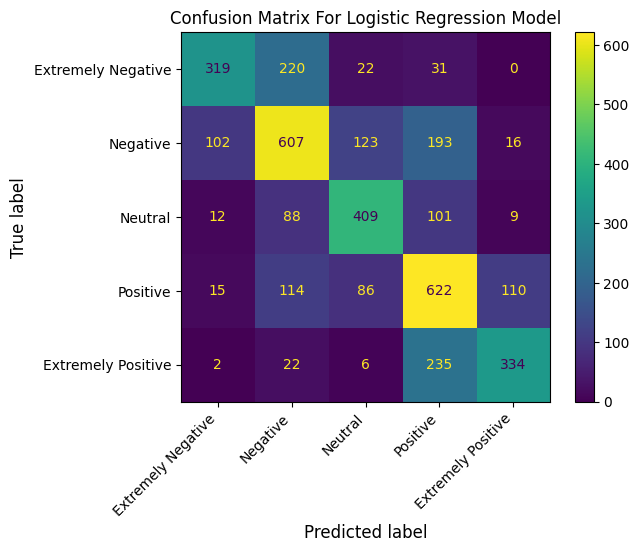

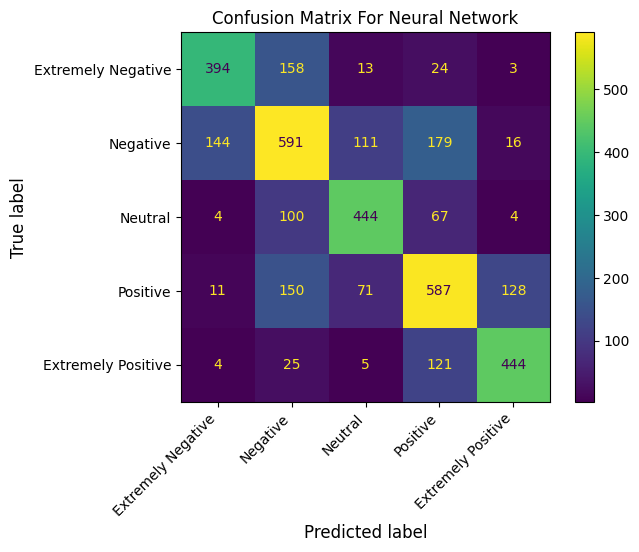

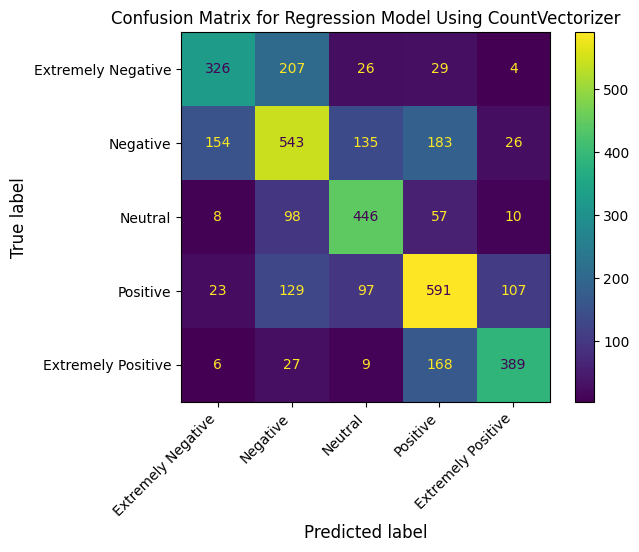

In [ ]:
#display confusion matrices for models - may need to label these, check how they display

regression_matrix = displayConfusion(testing_predictions, y_testing, 'Confusion Matrix For Logistic Regression Model')
nn_confusion_matrix = displayConfusion(predictions, true_labels, 'Confusion Matrix For Neural Network')
vectorizer_model_matrix = displayConfusion(y_pred, y_test, "Confusion Matrix for Regression Model Using CountVectorizer")

In [ ]:
#verify model sanity
print(predictions[15:40])
print(true_labels[15:40])

[3 2 3 4 2 1 3 1 4 2 4 1 2 1 1 3 4 1 3 1 1 1 3 2 2]
[2 2 3 4 2 1 3 2 4 2 3 1 1 0 1 1 4 1 3 0 1 2 1 2 2]
